# Classification with Multilayer Perceptrons

Here, we will introduce the simplest deep networks, which are called **multilayer perceptrons (MLP)**, and they consist of multiple layers of neurons each fully connected to those in the layer below (from which they receive input) and those above (which they, in turn, influence). 

MLP overcome the limitations of linear models by incorporating one or more hidden layers. The easiest way to do this is to stack many fully connected layers on top of one another. Each layer feeds into the layer above it, until we generate outputs. We can think of the first 
layers as our representation and the final layer as our linear predictor. 

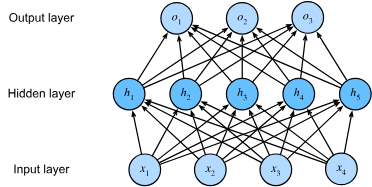



## Implementation of Multilayer Perceptrons

Multilayer perceptrons (MLPs) are not much more complex to implement than simple linear models. The key conceptual difference is that we now concatenate multiple layers.



### Initializing Model Parameters
The MNIST dataset contains 10 classes, and that each image consists of a $ 28 \times 28 = 784$ grid of grayscale pixel values. As before we will disregard the spatial structure among the pixels for now, so we can think of this as a classification dataset with 784 input features and 10 classes. 


In [14]:
from fastai.vision.all import *
path = untar_data(URLs.MNIST)


To begin, we will implement an MLP with one hidden layer and 256 hidden units. Both the number of layers and their width are adjustable (they are considered hyperparameters). Typically, we choose the layer widths to be divisible by larger powers of 2. This is computationally efficient due to the way memory is allocated and addressed in hardware.

Again, we will represent our parameters with several tensors. Note that for every layer, we must keep track of one weight matrix and one bias vector. As always, we allocate memory for the gradients of the loss with respect to these parameters.


In [15]:
num_hiddens = 256
num_outputs = 10
model = nn.Sequential(nn.Flatten(), nn.LazyLinear(num_hiddens),
                                 nn.ReLU(), nn.LazyLinear(num_outputs))

### Building the DataBlock

With our extraction pattern in place, we’ll use fastai’s `DataBlock` API to set up the data pipeline. `DataBlock` helps you organize and transform data for training, providing a flexible approach to defining inputs, outputs, and transformations.



In [16]:
dgt = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=RandomSplitter(seed=42),
    batch_tfms=aug_transforms()
)
dls = dgt.dataloaders(path)

#### Explanation of the `DataBlock` Parameters

- **`blocks=(ImageBlock, CategoryBlock)`**: Specifies that the input type is an image and the output is a category (label).
- **`get_items=get_image_files`**: Retrieves all image files within the specified path.
- **`get_y=parent_label`**: Retrieves the label for each image from the name of the parent folder.
- **`splitter=RandomSplitter(seed=42)`**: Randomly splits the dataset into training and validation sets. Setting a seed ensures consistency across runs.
- **`batch_tfms=aug_transforms(size=224, min_scale=0.75)`**: Performs batch-level transformations, such as applying data augmentation.



##  Validating the Data Pipeline

Before training, always verify the data pipeline. Errors or misaligned labels can lead to incorrect model training. We can check the data layout using `show_batch`:



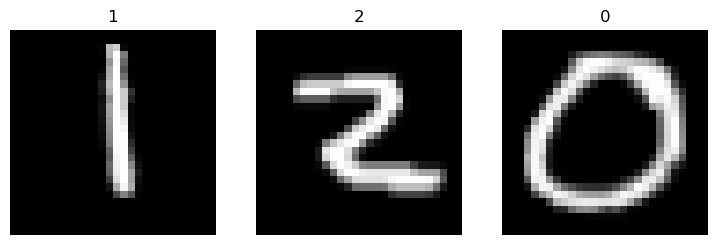

In [17]:
dls.show_batch(nrows=1, ncols=3)


This visualizes a batch of images and their labels, helping confirm that images match expected labels. If needed, use the `summary` method to display a detailed breakdown of data transformations and steps.


In [18]:
dgt.summary(path)

Setting-up type transforms pipelines
Found 70000 items
2 datasets of sizes 56000,14000
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      C:\Users\biagi\.fastai\data\mnist_png\training\7\48923.png
    applying PILBase.create gives
      PILImage mode=RGB size=28x28
  Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      C:\Users\biagi\.fastai\data\mnist_png\training\7\48923.png
    applying parent_label gives
      7
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(7)

Final sample: (PILImage mode=RGB size=28x28, TensorCategory(7))


Found 70000 items
2 datasets of sizes 56000,14000
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
Setting up a

##  Training the Model

Now that our data is ready, we can proceed to training. 


In [19]:
learn = Learner(dls, model, metrics=error_rate)
learn.fit(2)

epoch,train_loss,valid_loss,error_rate,time
0,0.397549,0.262883,0.077929,01:29
1,0.309400,0.186758,0.056429,01:24


The automatic calculation of gradients profoundly simplifies the implementation of deep learning algorithms. Before automatic differentiation, even small changes to complicated models required recalculating complicated derivatives by hand. Surprisingly often, academic papers had to allocate numerous pages to deriving update rules. While we must continue to rely on automatic differentiation so we can focus on the interesting parts, you ought to know how these gradients are calculated under the hood if you want to go beyond a shallow understanding of deep learning.


### Forward Propagation

*Forward propagation* (or *forward pass*) is the process of computing intermediate variables in a neural network from the input layer to the output layer.

Given an input $\mathbf{x}\in\mathbb{R}^d$, the hidden layer (without bias) first computes

$$
\mathbf{z} = \mathbf{W}^{(1)} \mathbf{x}, \quad \mathbf{W}^{(1)} \in \mathbb{R}^{h \times d}.
$$

Applying the activation function $\phi$ gives the hidden representation

$$
\mathbf{h} = \phi(\mathbf{z}), \quad \mathbf{h}\in\mathbb{R}^h.
$$

The output layer then produces

$$
\mathbf{o} = \mathbf{W}^{(2)} \mathbf{h}, \quad \mathbf{W}^{(2)} \in \mathbb{R}^{q \times h}.
$$

With a loss function $l$ and label $y$, the loss for a single example is

$$
L = l(\mathbf{o}, y).
$$

Including $\ell\_2$ regularization with hyperparameter $\lambda$, the penalty term is

$$
s = \tfrac{\lambda}{2}\left(\|\mathbf{W}^{(1)}\|_F^2 + \|\mathbf{W}^{(2)}\|_F^2\right),
$$

where $|\cdot|_F$ denotes the Frobenius norm.

Finally, the regularized objective function is

$$
J = L + s.
$$


### Backpropagation

*Backpropagation* is the method for computing gradients of neural network parameters by traversing the network in reverse, from output to input, using the chain rule of calculus. Intermediate partial derivatives are stored during the process.

For functions $\mathsf{Y}=f(\mathsf{X})$ and $\mathsf{Z}=g(\mathsf{Y})$, the chain rule gives

$$
\frac{\partial \mathsf{Z}}{\partial \mathsf{X}} = \text{prod}\!\left(\frac{\partial \mathsf{Z}}{\partial \mathsf{Y}}, \frac{\partial \mathsf{Y}}{\partial \mathsf{X}}\right),
$$

where $\text{prod}$ denotes the correct multiplication (matrix–matrix or tensor equivalent).

In our network with parameters $\mathbf{W}^{(1)}$ and $\mathbf{W}^{(2)}$, the objective is $J=L+s$, where $L$ is the loss and $s$ the $\ell\_2$ regularization term. The first gradients are straightforward:

$$
\frac{\partial J}{\partial L}=1, \qquad \frac{\partial J}{\partial s}=1.
$$

From here, we work backwards. The gradient with respect to the output layer variable is

$$
\frac{\partial J}{\partial \mathbf{o}} = \frac{\partial L}{\partial \mathbf{o}} \in \mathbb{R}^q.
$$

The regularization gradients are

$$
\frac{\partial s}{\partial \mathbf{W}^{(1)}} = \lambda \mathbf{W}^{(1)}, \qquad 
\frac{\partial s}{\partial \mathbf{W}^{(2)}} = \lambda \mathbf{W}^{(2)}.
$$

Thus, for the output layer parameters we obtain

$$
\frac{\partial J}{\partial \mathbf{W}^{(2)}} = \frac{\partial J}{\partial \mathbf{o}} \mathbf{h}^\top + \lambda \mathbf{W}^{(2)}.
$$

Moving to the hidden layer, the gradients are propagated as

$$
\frac{\partial J}{\partial \mathbf{h}} = {\mathbf{W}^{(2)}}^\top \frac{\partial J}{\partial \mathbf{o}}, 
$$

and, applying the elementwise derivative of the activation function,

$$
\frac{\partial J}{\partial \mathbf{z}} = \frac{\partial J}{\partial \mathbf{h}} \odot \phi'(\mathbf{z}).
$$

Finally, for the hidden layer parameters,

$$
\frac{\partial J}{\partial \mathbf{W}^{(1)}} = \frac{\partial J}{\partial \mathbf{z}} \mathbf{x}^\top + \lambda \mathbf{W}^{(1)}.
$$


### The Cross-Entropy Loss

In multi-class classification, the commonly used loss function is the *cross-entropy loss*, also known as log loss. 

This choice can be easily justified with maximum likelihood estimation.

The softmax function gives us a vector $\mathbf{p}$, which
we can interpret as the (estimated) conditional probabilities of each
class, given any input $\mathbf{x}$, such as $p_1$ =
$P(y=\textrm{cat} \mid \mathbf{x})$. 
In the following we assume that for a dataset with features $\mathbf{X}$ the labels
$\mathbf{Y}$ are represented using a one-hot encoding label
vector. We can compare the estimates with reality by checking how
probable the actual classes are according to our model, given the
features:

$$   P(\mathbf{Y} \mid \mathbf{X}) = \prod_{i=1}^n P(\mathbf{y}^{(i)} \mid \mathbf{x}^{(i)}). $$

We are allowed to use the factorization since we assume that each label
is drawn independently from its respective distribution
$P(\mathbf{y}\mid\mathbf{x}^{(i)})$. Then, we take the negative logarithm to obtain the
equivalent problem of minimizing the negative log-likelihood:

$$   -\log P(\mathbf{Y} \mid \mathbf{X}) = \sum_{i=1}^n -\log P(\mathbf{y}^{(i)} \mid \mathbf{x}^{(i)})
   = \sum_{i=1}^n l(\mathbf{y}^{(i)}, \mathbf{p}^{(i)}),$$

where for any pair of label $\mathbf{y}$ and model prediction
$\mathbf{p}$ over $C$ classes, the loss function
$L$ is

$$  L(\mathbf{y}, \mathbf{p}) = - \sum_{j=1}^C y_j \log \hat{y}_j. $$
  
This equation is commonly called the *cross-entropy
loss*. Since $\mathbf{y}$ is a one-hot vector of length $C$,
the sum over all its coordinates $j$ vanishes for all but one
term. Note that the loss $L(\mathbf{y}, \mathbf{p})$ is
bounded from below by $0$ whenever $\mathbf{p}$ is a
probability vector: no single entry is larger than $1$, hence
their negative logarithm cannot be lower than $0$;
$L(\mathbf{y}, \mathbf{p}) = 0$ only if we predict the
actual label with *certainty*. This can never happen for any finite
setting of the weights because taking a softmax output towards $1$
requires taking the corresponding input $o_i$ to infinity (or all
other outputs $o_j$ for $j \neq i$ to negative infinity).
Even if our model could assign an output probability of $0$, any
error made when assigning such high confidence would incur infinite loss
($-\log 0 = \infty$).

##  Interpreting the Model

After training, it’s helpful to interpret the model’s performance to understand areas of improvement. A confusion matrix is useful for identifying patterns in misclassifications.


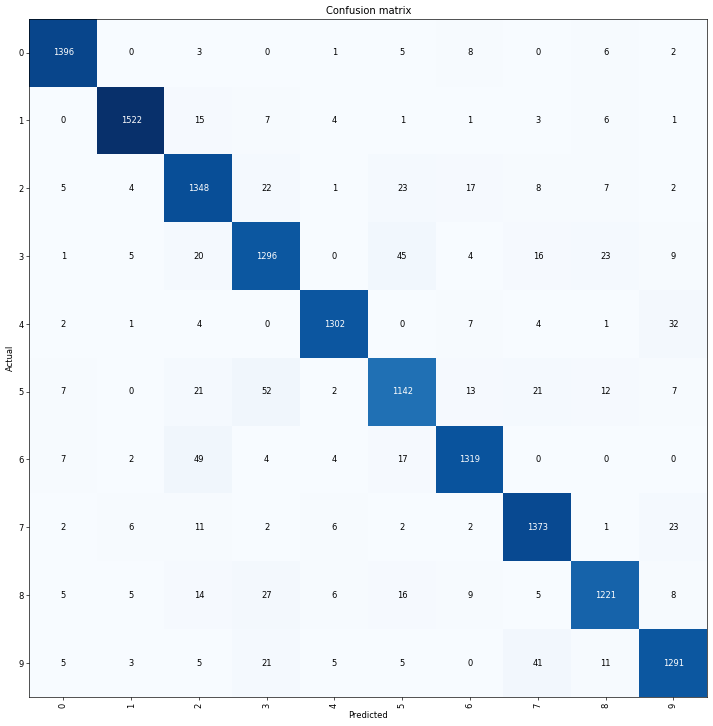

In [20]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)



When dealing with a large number of classes, the confusion matrix can become complex. The `most_confused` method highlights the most common errors:


In [23]:
interp.most_confused(min_val=25)


[('5', '3', 52),
 ('6', '2', 49),
 ('3', '5', 45),
 ('9', '7', 41),
 ('4', '9', 32),
 ('8', '3', 27)]


This output shows which breeds the model often confuses, providing insights into areas needing improvement.



##  Improving the Model

### The Learning Rate

The learning rate $ \eta $ controls the step size in the gradient descent optimization process. At each training step, the model updates its weights $ w $ in the opposite direction of the gradient $ \nabla L(w) $ of the loss function $ L $ with respect to the weights. This update rule is:

$$
w_{i+1} = w_i - \eta \nabla L(w_i)
$$

If $ \eta $ is too large, the model may overshoot the optimal weights, causing unstable training. If $ \eta $ is too small, training may take too long to converge. The optimal learning rate is usually found by experimenting or using a learning rate finder.

### Learning Rate Finder

The learning rate finder in fastai allows us to identify a suitable learning rate by gradually increasing it and observing the effect on the loss. Here’s how to apply it:


c:\Users\biagi\anaconda3\envs\book\Lib\site-packages\fastai\learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torc

Minimum/10: 1.32e-07, steepest point: 1.10e-06


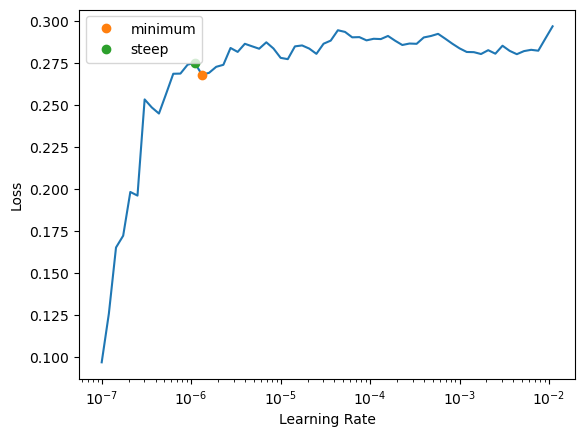

In [22]:
lr_min, lr_steep = learn.lr_find(suggest_funcs=(minimum, steep))
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

> Note: Logarithmic Scale: The learning rate finder plot has a logarithmic scale, which is why the middle point between 1e-3 and 1e-2 is between 3e-3 and 4e-3. This is because we care mostly about the order of magnitude of the learning rate.


The learning rate plot helps identify a rate that minimizes loss without diverging. Choose a rate slightly lower than the minimum or steepest point, around 3e-3 in this case.



### Early Stopping

Deep neural networks can eventually memorize even random labels (Zhang et al., 2021). However, research shows they fit clean labels first and only later adapt to mislabeled ones (Rolnick et al., 2017). This leads to an important insight: if a model fits the correct labels but not the noisy ones, it has generalized (Garg et al., 2021).

This motivates **early stopping**, a classic regularization method. Instead of limiting weights directly, we limit the training duration. The usual practice is to monitor validation error at each epoch and stop when it fails to improve beyond a small threshold for a set number of epochs, often called the *patience criterion*.

Early stopping offers two advantages:

1. Better generalization in the presence of noisy labels.
2. Reduced training cost and time, especially for large models requiring multi-GPU setups.

When data is noise-free and fully separable (e.g., cats vs. dogs), early stopping rarely improves generalization. But in cases with label noise or inherent uncertainty (e.g., predicting patient outcomes), stopping before the model memorizes noise is essential.


### Dropout

A good predictive model should generalize well to unseen data. Classical theory links generalization to *simplicity*, which can mean low dimensionality, small parameter norms (as in weight decay), or smoothness—insensitivity to small perturbations in the input. For example, image classifiers should be robust to minor pixel noise.

Bishop (1995) showed that training with input noise is equivalent to Tikhonov regularization, formalizing the link between smoothness and robustness. Building on this idea, Srivastava et al. (2014) proposed **dropout**, a technique that applies noise to the *internal layers* of neural networks. During training, dropout randomly “drops” (zeros out) a fraction of neurons at each iteration, preventing layers from relying too heavily on specific activation patterns—a problem they call *co-adaptation*.

The mechanism is simple: with dropout probability $p$, each activation $h$ is replaced by

$$
\tilde{h} = \begin{cases} 
0 & \text{with prob. } p, \\ 
\frac{h}{1-p} & \text{with prob. } 1-p,
\end{cases}
$$

so that the expectation $ \mathbb{E}[\tilde{h}] = h $ remains unchanged.

Typically, dropout is diabled at test time. Given a trained model and a new example, we do not drop out any nodes and thus do not need to normalize. However, there are some exceptions: some researchers use dropout at test time as a heuristic for estimating the uncertainty of neural network predictions: if the predictions agree across many different dropout outputs, then we might say that the network is more confident.

Dropout has become a standard regularization method in deep learning, helping models avoid overfitting and improving generalization, especially when training large networks.


### Further Optimization: Selecting Epochs and Avoiding Overfitting

Choosing the number of epochs is a balancing act. Too few epochs can result in underfitting, while too many can lead to overfitting. Here are some general guidelines:

- Start with a few epochs to see baseline performance.
- Monitor validation loss and accuracy over epochs to determine when the model starts overfitting.
- Use early stopping or cross-validation if needed.

If training resources allow, try experimenting with larger models or deeper architectures. However, always validate if additional complexity improves your specific task.